In [1]:
%matplotlib inline

from tqdm import tqdm
import json

import numpy as np
import pandas as pd

import scipy.sparse.linalg
from scipy import sparse, stats, spatial

import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt
import seaborn as sns

import random

from helpers_satcat import *

## SATCAT launch site analysis 

In this analysis, we will attempt to identify from which launch site a satellite has been launched from informations provided by the SATCAT database, such as its orbital parameters, country of origin, nature, etc.

The goal will be to identify satellites launch site by using only a subset of labeled satellites.
We want to see what type of precision we can obtain with graph-based analysis.


### SATCAT data extraction

To have a cleaner notebook, we extracted the data from the SATCAT dataset using an external script, called *create_satcat_json.py*.

This script generates a json file containing the formatted SATCAT data and more complete information on the files.

#### Extract celestrack SATCAT data

In [2]:
with open("Dataset/satcat_info.json") as f:
    satcat_info_json = json.load(f)

In [3]:
# Extract the main dataset and put it in a dataframe
sat_info_array = satcat_info_json["sat_data"]
satcat_df = pd.DataFrame(sat_info_array)
satcat_df = satcat_df.set_index("NORAD")
display(satcat_df.head(5))

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
1,938.0,1957-12-01,65.1,1957-10-04,1,A,TYMSC,1957,False,SL-1 R/B,Decayed,96.2,EA,False,214.0,20.420,CIS
2,945.0,1958-01-03,65.0,1957-10-04,1,B,TYMSC,1957,False,SPUTNIK 1,Decayed,96.1,EA,True,227.0,NaN,CIS
3,1659.0,1958-04-14,65.3,1957-11-03,2,A,TYMSC,1957,False,SPUTNIK 2,Decayed,103.7,EA,True,211.0,0.080,CIS
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,NaN,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US


In [4]:
# Extract complementary information dictionary
operational_status_dict = satcat_info_json["operational_status"]
launch_site_full_name_dict = satcat_info_json["launch_site"]
source_full_name_dict = satcat_info_json["source"]

#### Fill NaN in satcat data

In [5]:
satcat_df = satcat_df.fillna(value=0)
display(satcat_df.head(5))

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source
NORAD,,,,,,,,,,,,,,,,,
1,938.0,1957-12-01,65.1,1957-10-04,1,A,TYMSC,1957,False,SL-1 R/B,Decayed,96.2,EA,False,214.0,20.420,CIS
2,945.0,1958-01-03,65.0,1957-10-04,1,B,TYMSC,1957,False,SPUTNIK 1,Decayed,96.1,EA,True,227.0,0.000,CIS
3,1659.0,1958-04-14,65.3,1957-11-03,2,A,TYMSC,1957,False,SPUTNIK 2,Decayed,103.7,EA,True,211.0,0.080,CIS
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US


### Data Exploration

In this section, we want to see how the different parameters of the satellites behave.

To do so, we will analyze the various parameters.
We used a systematic approach, where for each parameter of interest, we did a short analysis

#### Launch site 

In [6]:
# Create dict to transform launch site to numerical value
num_launch_site_dict = {}
for index,site in enumerate(satcat_df.launch_site.unique()):
    num_launch_site_dict[site] = index

In [7]:
num_launch_site = satcat_df.launch_site.map(lambda x:num_launch_site_dict[x])
num_launch_site.name = "num_launch_site"
satcat_df = pd.concat([satcat_df,num_launch_site], axis=1)

In [8]:
# How many launch per site
launches_per_site = satcat_df.launch_site.value_counts()
display(launches_per_site.head(5))

TYMSC    11241
PLMSC    11160
AFWTR     6982
TAISC     4380
AFETR     3271
Name: launch_site, dtype: int64

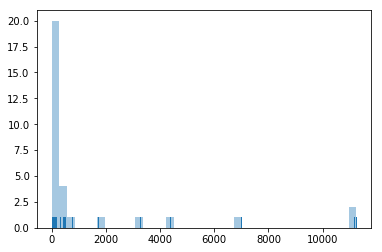

In [9]:
sns.distplot(launches_per_site.values,kde=False, rug=True)
plt.savefig("fig/satcat_launches_per_site.png")
plt.show()

#### Country of origin

In [10]:
# Create dict to transform launch site to numerical value
num_source_dict = {}
for index,site in enumerate(satcat_df.source.unique()):
    num_source_dict[site] = index

In [11]:
# How many launch per sources
launches_per_source = satcat_df.source.value_counts()
display(launches_per_source.head(5))

CIS    21491
US     11387
PRC     5192
FR      1263
IND      536
Name: source, dtype: int64

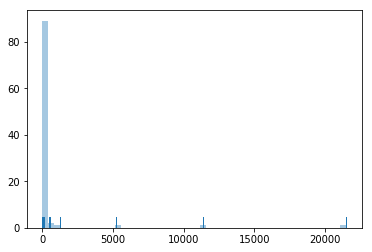

In [12]:
sns.distplot(launches_per_source.values,kde=False, rug=True)
plt.savefig("fig/satcat_launches_per_source_count.png")
plt.show()

#### Operational Status

In [13]:
num_operational_status_dict = {}
for index, status in enumerate(satcat_df.operational_status.unique()):
    num_operational_status_dict[status] = index
print(num_operational_status_dict)

{'Decayed': 0, 'Unknown': 1, 'Nonoperational': 2, 'Operational': 3, 'Partially Operational': 4, 'Backup/Standby': 5, 'Spare': 6, 'Extended Mission': 7}


In [14]:
# How many satellites per operational status
operational_status_count = satcat_df.operational_status.value_counts()
display(operational_status_count)

Decayed                  23970
Unknown                  15041
Operational               1754
Nonoperational            1070
Partially Operational       53
Backup/Standby              17
Spare                        2
Extended Mission             2
Name: operational_status, dtype: int64

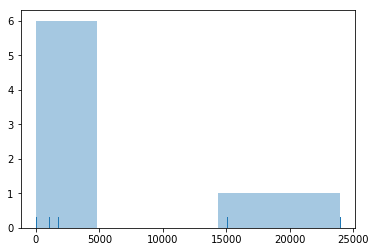

In [15]:
sns.distplot(operational_status_count.values,kde=False, rug=True)
plt.savefig("fig/satcat_operational_status_count.png")
plt.show()

#### Orbital status

See: https://celestrak.com/satcat/satcat-format.asp 
Orbital Status Code for the meaning of the code

In [16]:
orbital_statuses = satcat_df.orbital_status.unique()
print(len(orbital_statuses), "\n", orbital_statuses)

8 
 ['EA' 'NEA' 'EA2' 'MO2' 'MA0' 'EL0' 'DOC' 'ISS']


In [17]:
num_orbital_status_dict = {}
for index, status in enumerate(orbital_statuses):
    num_orbital_status_dict[status] = index
print(num_orbital_status_dict)

{'EA': 0, 'NEA': 1, 'EA2': 2, 'MO2': 3, 'MA0': 4, 'EL0': 5, 'DOC': 6, 'ISS': 7}


In [18]:
# How many satellites per orbital status
orbital_status_count = satcat_df.orbital_status.value_counts()
display(orbital_status_count)

EA     41832
NEA       68
ISS        4
DOC        1
MO2        1
EL0        1
EA2        1
MA0        1
Name: orbital_status, dtype: int64

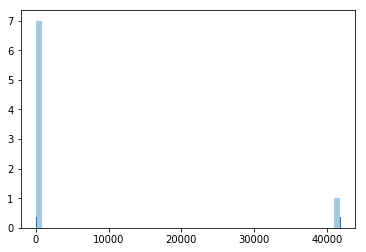

In [19]:
sns.distplot(orbital_status_count.values,kde=False, rug=True)
plt.savefig("fig/satcat_orbital_status_count.png")
plt.show()


#### Orbital Parameters

For each orbital parameters we want to do a distribution analysis by launch site

In [20]:
ORBITAL_PARAMETERS_COLS = ["apogee", "inclination", "launch_year", "orbital_period", "perigee"] 

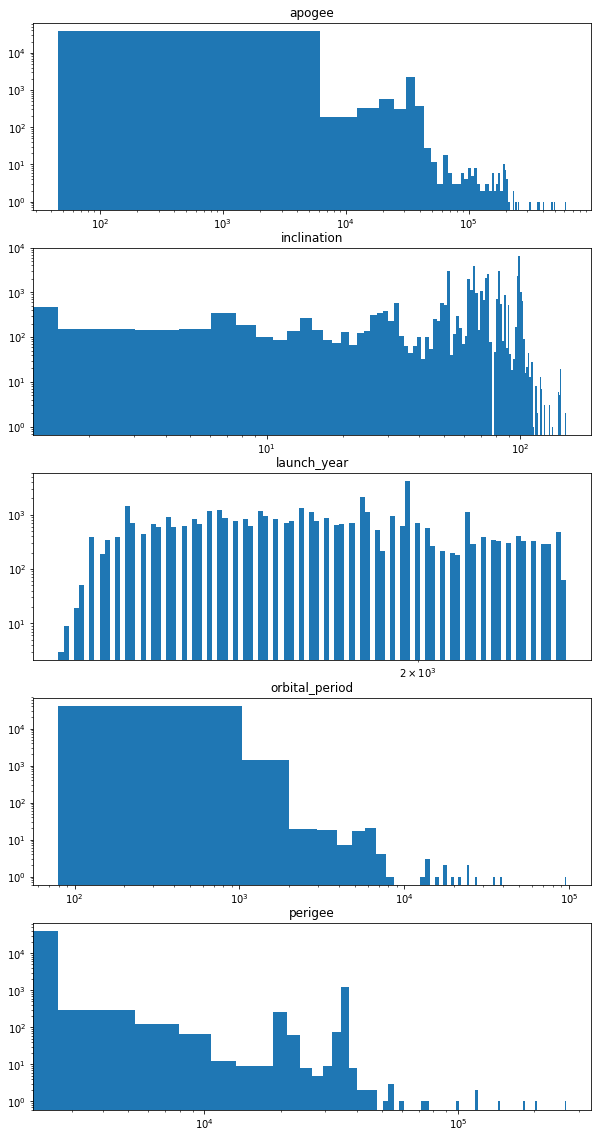

In [21]:
fig, axes = plt.subplots(len(ORBITAL_PARAMETERS_COLS), 1, figsize=(10,20))

for index, parameter in enumerate(ORBITAL_PARAMETERS_COLS):
    axes[index].hist(satcat_df[parameter].values, bins=100);
    axes[index].set_xscale("log")
    axes[index].set_yscale("log")
    axes[index].set_title(parameter)
plt.savefig("fig/satcat_orbital_params.png")
plt.show()

### Data reduction 

To do clustering, we want to reduce the complexity of the target clusters. 

To do so, we will first reduce the number of launch sites and/or sources.

We tried two methods:

    1. Using percentiles of the value counts, so it can be easily adapted depending on the desired results.
    2. Using specific launch sites

The method using specific launch sites "AFETR" and "AFWTR", which where the main launch sites for the United-States of America, gave the best results.

In [22]:
REDUCE_PER_PERCENTILE = False # Reduction per percentile didn't work as expected
REDUCE_PER_LAUNCH_SITE = True # Attempt to segment by country: there might be reasons for using particular sites
TARGET_PERCENTILE_LAUNCH_SITES = 90
TARGET_PERCENTILE_SOURCES = 90
LAUNCH_SITES = ["AFETR", "AFWTR"]

In [23]:
if REDUCE_PER_PERCENTILE:
    reduced_satcat_df = data_reduction_per_percentile(satcat_df, TARGET_PERCENTILE_LAUNCH_SITES, TARGET_PERCENTILE_SOURCES)

In [24]:
if REDUCE_PER_LAUNCH_SITE:
    reduced_satcat_df = data_reduction_per_launch_site(satcat_df, LAUNCH_SITES)

In [25]:
print(reduced_satcat_df.source.unique())
display(reduced_satcat_df.head(5))

['US' 'UK' 'ITSO' 'ESRO' 'NATO' 'CA' 'FGER' 'INDO' 'ESA' 'JPN' 'IT' 'IND'
 'ARGN' 'GER' 'AB' 'MEX' 'AUS' 'RP' 'SWED' 'NOR' 'IM' 'EUTE' 'NETH' 'GREC'
 'BRAZ' 'SES' 'SKOR' 'ABS' 'PAKI' 'GLOB' 'CIS' 'ROC' 'SPN' 'NICO' 'AC'
 'ORB' 'THAI' 'TMMC' 'BUL' 'FR' 'DEN' 'SAFR']


,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source,num_launch_site
NORAD,,,,,,,,,,,,,,,,,,
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US,1
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US,1
6,1739.0,1958-06-28,33.5,1958-03-26,3,A,AFETR,1958,False,EXPLORER 3,Decayed,103.6,EA,True,117.0,0.000,US,1
9,585.0,1959-10-23,50.3,1958-07-26,5,A,AFETR,1958,False,EXPLORER 4,Decayed,92.8,EA,True,239.0,0.000,US,1
10,1187.0,1959-01-21,32.3,1958-12-18,6,A,AFETR,1958,False,SCORE,Decayed,98.2,EA,True,159.0,0.000,US,1


#### Reduce by payload or operational

To reduce even more the size of the dataset, we can chose to keep only payloads and/or operational satellites in the dataset.

We chose to keep only payloads, because the dataset has many other types, such as debris and launchers, which are not really interesting for our analysis.

We chose to use all historic satellites to have more data on which to work.
Also historic satellites are likely to follow similar orbits as modern satellites.

In [26]:
ONLY_PAYLOAD=True
ONLY_OPERATIONAL=False
print("Length before further reduction: ", len(reduced_satcat_df))
if ONLY_PAYLOAD:
    reduced_satcat_df = reduced_satcat_df.loc[reduced_satcat_df.payload_flag == True]
if ONLY_OPERATIONAL:
    reduced_satcat_df = reduced_satcat_df.loc[reduced_satcat_df.operational_status == "Operational"]
    
print("Length after reduction: ", len(reduced_satcat_df))

Length before further reduction:  10253
Length after reduction:  1743


### Extract Features and Labels

#### Create Features DataFrame

We now want to extract the features for each satellite. 
As a first glance, we want to keep as much data as possible. Later on we might drop some features.

In [27]:
display(reduced_satcat_df.head(5))

,apogee,decay_date,inclination,launch_date,launch_nbr,launch_piece,launch_site,launch_year,multiple_name_flag,name,operational_status,orbital_period,orbital_status,payload_flag,perigee,radar_cross_section,source,num_launch_site
NORAD,,,,,,,,,,,,,,,,,,
4,215.0,1970-03-31,33.2,1958-02-01,1,A,AFETR,1958,False,EXPLORER 1,Decayed,88.5,EA,True,183.0,0.000,US,1
5,3834.0,,34.3,1958-03-17,2,B,AFETR,1958,False,VANGUARD 1,Unknown,132.8,EA,True,650.0,0.122,US,1
6,1739.0,1958-06-28,33.5,1958-03-26,3,A,AFETR,1958,False,EXPLORER 3,Decayed,103.6,EA,True,117.0,0.000,US,1
9,585.0,1959-10-23,50.3,1958-07-26,5,A,AFETR,1958,False,EXPLORER 4,Decayed,92.8,EA,True,239.0,0.000,US,1
10,1187.0,1959-01-21,32.3,1958-12-18,6,A,AFETR,1958,False,SCORE,Decayed,98.2,EA,True,159.0,0.000,US,1


In [28]:
satcat_df.orbital_status.unique()

array(['EA', 'NEA', 'EA2', 'MO2', 'MA0', 'EL0', 'DOC', 'ISS'], dtype=object)

In [29]:
reduced_satcat_df.orbital_status.unique()

array(['EA', 'NEA', 'EA2', 'ISS'], dtype=object)

In [30]:
# Note: because this function is key to understanding how we create the features, we kept it in the notebook

def get_feature_dataframe(reduced_satcat_df, only_payload=True, only_operational=False):
    """Function to create the feature dataframe"""
    # We keep all the features that could have an impact on the clustering
    # Note: We do this in a general fashion, so we keep features that could have been reduced just in case

    # Numeric Features : "apogee", "inclination", "launch_year", "orbital_period", "perigee", "radar_cross_section"
    # Boolean Features : "payload_flag"
    # List Features    : "operational_status", "orbital_status", "source"
    numeric_features = ["apogee", "inclination", "launch_year", "orbital_period", "perigee", "radar_cross_section"]
    boolean_features = ["payload_flag"]
    list_features = ["operational_status", "orbital_status", "source"]
    features_columns = numeric_features + boolean_features + list_features

    # Numeric features don't require special management
    features_df = reduced_satcat_df[numeric_features]
    display(features_df.head(5))

    # Transform boolean features to numeric
    num_payload_flag = reduced_satcat_df.payload_flag.map (\
                                lambda x : 1 if x else 0
                       )
    if not only_payload:
        features_df = features_df.assign(payload_flag = num_payload_flag)

    # We need to transform the List features in a numerical form, we will use the unique value index to do so
    # We previously created indexes to be able to find them easily
    # "operational_status" : num_operational_status_dict
    # "orbital_status" : num_orbital_status_dict
    # "source": num_source_dict
    num_operational_status = reduced_satcat_df.operational_status.map( \
                                    lambda x : num_operational_status_dict[x] \
                             )
    num_orbital_status = reduced_satcat_df.orbital_status.map( \
                                    lambda x : num_orbital_status_dict[x] \
                             )
    num_source = reduced_satcat_df.source.map( \
                                    lambda x : num_source_dict[x] \
                             )
    if not only_operational:
        features_df = features_df.assign(operational_status = num_operational_status)
    features_df = features_df.assign(orbital_status = num_orbital_status)
    features_df = features_df.assign(source = num_source)
    
    return features_df

In [31]:
features_df = get_feature_dataframe(reduced_satcat_df, ONLY_PAYLOAD, ONLY_OPERATIONAL)
display(features_df.head(5))

,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section
NORAD,,,,,,
4,215.0,33.2,1958,88.5,183.0,0.000
5,3834.0,34.3,1958,132.8,650.0,0.122
6,1739.0,33.5,1958,103.6,117.0,0.000
9,585.0,50.3,1958,92.8,239.0,0.000
10,1187.0,32.3,1958,98.2,159.0,0.000


,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section,operational_status,orbital_status,source
NORAD,,,,,,,,,
4,215.0,33.2,1958,88.5,183.0,0.000,0,0,1
5,3834.0,34.3,1958,132.8,650.0,0.122,1,0,1
6,1739.0,33.5,1958,103.6,117.0,0.000,0,0,1
9,585.0,50.3,1958,92.8,239.0,0.000,0,0,1
10,1187.0,32.3,1958,98.2,159.0,0.000,0,0,1


#### Normalize features

In [32]:
features_df = normalize_features(features_df)
display(features_df.head(5))

,apogee,inclination,launch_year,orbital_period,perigee,radar_cross_section,operational_status,orbital_status,source
NORAD,,,,,,,,,
4,-0.390693,-0.766486,-1.44112,-0.192732,-0.501090,-0.171139,-0.943187,-0.109093,-0.312776
5,-0.285957,-0.734247,-1.44112,-0.176636,-0.473941,-0.168288,-0.147073,-0.109093,-0.312776
6,-0.346588,-0.757693,-1.44112,-0.187246,-0.504927,-0.171139,-0.943187,-0.109093,-0.312776
9,-0.379985,-0.265311,-1.44112,-0.191170,-0.497834,-0.171139,-0.943187,-0.109093,-0.312776
10,-0.362563,-0.792864,-1.44112,-0.189208,-0.502485,-0.171139,-0.943187,-0.109093,-0.312776


#### Create Label Dataframe

In [33]:
num_launch_site = reduced_satcat_df.num_launch_site
label_df = pd.DataFrame(num_launch_site)
display(label_df.head(5))

,num_launch_site
NORAD,
4,1
5,1
6,1
9,1
10,1


### Graph data visualization 

#### Distances

Using the features we calculate, we want to find the distance between the feature vectors.

In [34]:
distance_metric = "braycurtis"
distances = spatial.distance.squareform(spatial.distance.pdist(features_df, metric=distance_metric))

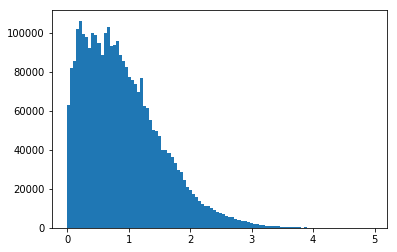

In [35]:
plt.hist(distances.reshape(-1), bins=100)
plt.savefig("fig/satcat_distances_hist.png")
plt.show()

In [36]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))
print(len(distances))

2027 distances equal exactly zero.
1743


#### Weights

In [37]:
KERNEL_WIDTH_PERCENTILE = 0.5
weights = get_weights_from_distance(distances, KERNEL_WIDTH_PERCENTILE)
# Validate that all the weights on the diagonal are null
print(np.sum(np.diagonal(weights)==0))
print(len(weights))

1743
1743


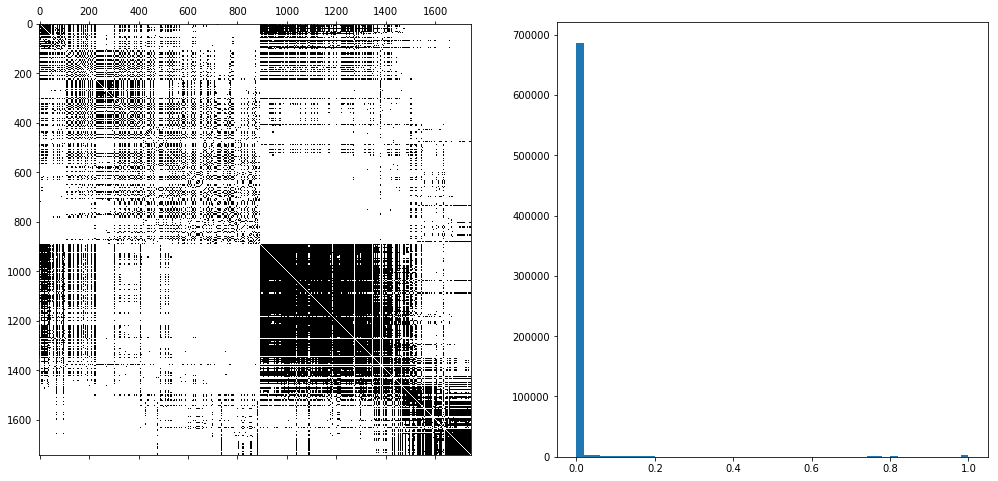

In [38]:
# Plot the resulting weight value
fix, axes = plt.subplots(1, 2, figsize=(17, 8))
plot_weight_hist(weights, axes[:], name="satcat_base_weight_hist")
plt.show()

#### Sparcify

100%|██████████| 1743/1743 [00:02<00:00, 801.59it/s] 


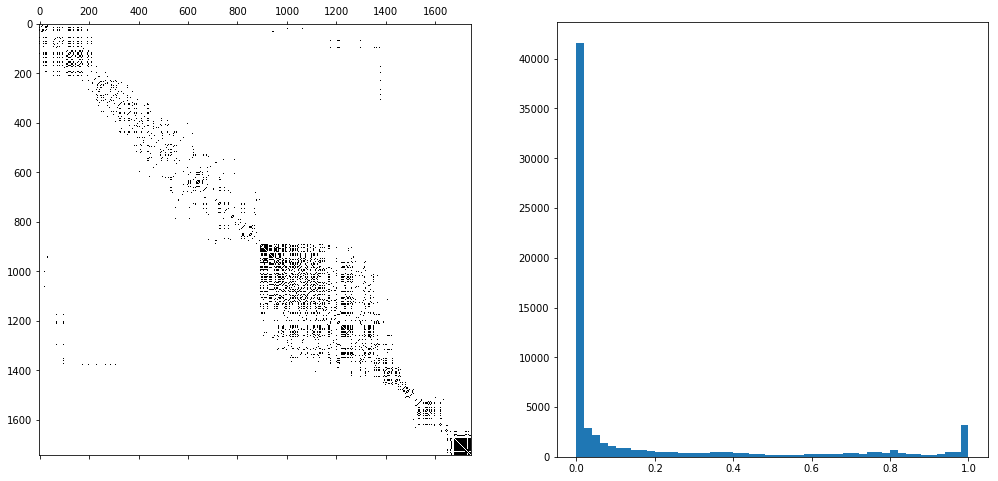

In [39]:
NEIGHBORS = 100
epsilon = 1e-8

weights = sparse_weights(weights, NEIGHBORS, epsilon)
fix, axes = plt.subplots(1, 2, figsize=(17, 8))
plot_weight_hist(weights, axes[:], name="satcat_sparse_weight_hist")

#### Graph laplacian

The graph laplacian can give use meaningfull information on the nodes distribution

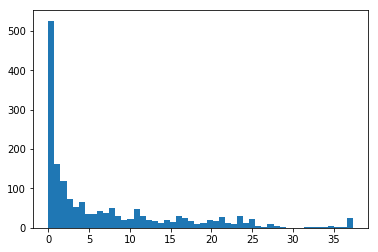

In [ ]:
degrees = np.sum(weights, axis=1) 
plt.hist(degrees, bins=50);
plt.savefig("fig/satcat_laplacian_degree.png")
plt.show()

In [ ]:
laplacian = np.zeros((len(degrees), len(degrees)))
laplacian.flags.writeable = True

for i in tqdm(range(len(degrees))):
    for j in range(len(degrees)):
        #print(i,j, flush=True)
        if i==j:
            laplacian[i][j] = 1
        else:
            square_root = np.sqrt(degrees[i]*degrees[j])
            # Avoid divide by 0
            # Check if we should put 1 or 0 here...
            if square_root == 0.0:
                laplacian[i][j] = 0.0
            else:
                laplacian[i][j] = -weights[i][j]/square_root
            

 19%|█▉        | 334/1743 [00:01<00:06, 226.26it/s]

In [ ]:
fix, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].spy(laplacian);
axes[0].set_title("Laplacian matrix")
axes[1].spy(weights)
axes[1].set_title("Weights matrix")
plt.savefig("fig/laplacian_and_weight_matrix.png")
plt.show()

In [ ]:
laplacian = sparse.csr_matrix(laplacian)

In [ ]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(laplacian,
                                                k=len(weights)-1,
                                                maxiter=100000,
                                                which='SA')
plt.plot(eigenvalues, '.-', markersize=5);
plt.savefig("fig/satcat_laplacian_eigenvalues.png")
plt.show()

In [ ]:
min_index = 0
for index, value in enumerate(eigenvalues):
    if value > 0.01:
        min_index = index
        break
print(min_index)

In [ ]:
NBR_OF_GRAPH = 10
fig, axes = plt.subplots(NBR_OF_GRAPH//2,2,figsize=(10,15))
for index in range(NBR_OF_GRAPH):
    x = eigenvectors[:, index]
    y = eigenvectors[:, index+1]
    axes[index//2][index %2].scatter(x, y, c=label_df.num_launch_site.values, cmap='Set1', alpha=0.5);
    axes[index//2][index %2].set_title("{}".format(index))
plt.savefig("fig/satcat_laplacian_results.png")
plt.show()

### Graph analysis using networkx

We see from the Laplacian analysis that there's signs of clustering in the data, but we don't obtain a simple clustering with data to the left and to the right.

To identify the actual clustering, we will need to do more complete network analysis.
We will use networkx as the main tool for this step.

In [ ]:
graph = create_graph_from_weights(weights, reduced_satcat_df)

In [ ]:
print(graph.node[0])

#### Draw the network

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
draw_graph(graph, axes, reduced_satcat_df, name="base_graph")
plt.show()

#### Filter the graph degree

We will first remove nodes with small amount of edges, because we can see that they don't really provide information on the clusters.

**NOTE:** 

    1.This is used only to remove the nodes with a degree of 0, because we want to keep small degree nodes for the next steps.
    2.We keep the code to show how we progressed through the task

In [ ]:
# Filter out lonely nodes
MINIMUM_DEGREE = 0 
print(len(graph.nodes))
graph = remove_lonely_nodes(graph, minimum_degree = MINIMUM_DEGREE)
print(len(graph.nodes))
# Do it again to remove resulting nodes with degree of 0
# Only if the minimum degree is greater than 0, otherwise 
# it would simply repeat the same thing
if MINIMUM_DEGREE > 0:
    graph = remove_lonely_nodes(graph, minimum_degree = 0)
print(len(graph.nodes))

In [ ]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
draw_graph(graph, axes, reduced_satcat_df, name="cleaned_base_graph")
plt.show()

We can see that there's clearly some major clusters appearing in the graph. 
The next step will be to attempt to segregate those clusters and extract see if we can identify they came from which launch site, and to which precision we can identify them.

##### Separate the graph into connected subgraphs

In [ ]:
connected_subgraphs = []
for subgraph in  nx.connected_component_subgraphs(graph):
    connected_subgraphs.append(nx.Graph(subgraph))
print(len(connected_subgraphs))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))
print_subgraphs_nodes_dist(connected_subgraphs, axes)
plt.show()

We node that there's a lot of small graphs, without many nodes.
For the visual analysis, we will only use a subset of the graphs, otherwise there would be too many plots

In [ ]:
nodes_nbr = get_nodes_nbr(connected_subgraphs)
MINIMUM_NBR_OF_NODES = np.percentile(nodes_nbr,
                                     80)
small_subgraphs = [connected_subgraphs[index] for index, val in enumerate(nodes_nbr) if val < MINIMUM_NBR_OF_NODES]
kept_subgraphs = [connected_subgraphs[index] for index, val in enumerate(nodes_nbr) if val >= MINIMUM_NBR_OF_NODES]
print(len(kept_subgraphs))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5,3))
print_subgraphs_nodes_dist(kept_subgraphs, axes)
plt.show()

In [ ]:
print_subgraphs_network(kept_subgraphs, reduced_satcat_df, name = "subgraph_networks_before_clique")

##### Separate the biggest graph in subgraphs

We see from the result above that most subgraphs are well separated but for the largest subgraph.

To improve the results, we will separate the bigger subgraphs into smaller ones.

To determine how we will end the separation, we will separate the bigger graphs in cliques.

In [ ]:
MAXIMUM_SUBGRAPH_NODES_PERCENT = 0.20 # How many nodes you need to be a big subgraph
maximum_subgraph_nodes = int(len(graph.nodes)*MAXIMUM_SUBGRAPH_NODES_PERCENT)

# Get the index of the big subgraphs
big_subgraphs_index = get_big_subgraphs_index(kept_subgraphs,
                                              maximum_subgraph_nodes
                                             )
print(big_subgraphs_index)

In [ ]:
# Segment the big subgraphs into cliques
SIZE_OF_SMALLEST_CLIQUE = 20
clique_subgraphs = []
for subgraph_index in big_subgraphs_index:
    current_subgraph = kept_subgraphs[subgraph_index]
    current_subgraphs = get_graph_cliques(current_subgraph,
                                          smallest_clique=SIZE_OF_SMALLEST_CLIQUE
                                         )
    clique_subgraphs += current_subgraphs
print(get_nodes_nbr(clique_subgraphs))

In [ ]:
# Construct a new subgraph without the subgraphs that where
# divided in cliques, but with the cliques
kept_subgraphs_no_big = [subgraph for index, subgraph in enumerate(kept_subgraphs)
                         if not index in big_subgraphs_index]
print(get_nodes_nbr(kept_subgraphs))
print(get_nodes_nbr(kept_subgraphs_no_big))

In [ ]:
# Merge the subgraphs
subgraphs = clique_subgraphs + kept_subgraphs_no_big + small_subgraphs
print(get_nodes_nbr(subgraphs))
print(sum(get_nodes_nbr(subgraphs)))
print(len(subgraphs))

In [ ]:
print_subgraphs_network(subgraphs[:16], reduced_satcat_df, name = "subgraph_networks_after_clique")

### Label the subgraphs and the nodes

Although we have used coloring in the graphs to show the launch site of each node, the algorithm doesn't have any information on the actual label to give to each node.

In this section, we will provide the algorithm with a subset of the nodes that have an actual label.
From there, we will try to give a probability of each subgraph to represent satellites that have been launched by a particular launch site.

We will then identify the nodes of each subgraph in bulk by using the most probable launch site.
If the probability is equal or we don't know it (i.e. we don't have any node with a label in the graph) we will identify the node launch site as "unknown".

Finally, we will compare the results with the actual 

#### Create the labeled subset of nodes

First create an array with all nodes, their label and if they were part of the labeled subset.

If they are unidentified, their label will be -1.

The label will be the the numerical value given by
num_launch_site.

In [ ]:
PERCENT_OF_LABELED = 30
label_df = create_labeled_df(reduced_satcat_df, PERCENT_OF_LABELED) 
print(label_df.head(5))
print("Number of labeled sats: {}".format(label_df.is_labeled.sum()))
print("Total number of sats: {}".format(len(label_df)))

#### Calculate launch site probability of each subgraph

In [ ]:
subgraph_probabilities = [get_label_probs(label_df, subgraph) for subgraph in subgraphs]
print(subgraph_probabilities)

#### Identify the nodes of each subgraph

In [ ]:
label_df = identify_nodes_from_prob(label_df, subgraphs)
display(label_df.head())

In [ ]:
nodes_nbr = [len(graph.nodes) for graph in subgraphs]
sum(nodes_nbr)
print(len(nodes_nbr))
print(len(label_df))

In [ ]:
sns.distplot(label_df.label, kde=False, rug=True)
plt.show()

#### Calculate the error of the labels

In [ ]:
error = {}
values = range(0,101,1)#[0, 1, 2, 5, 10, 20, 40, 60, 80, 90, 100]
for percent_labeled in values:
    labeled_df = get_labeled_df(reduced_satcat_df, subgraphs, percent_labeled)
    error[percent_labeled] = get_error_properties(labeled_df, reduced_satcat_df, show=False)

key_of_interest = [0, 1, 2, 5, 10, 20, 40, 60, 80, 100]
for key in key_of_interest:
    print("Fraction of labelized data: {} %, error: {}, unidentified:{}".format(key,
                                                                                error[key]["good_classification_percent"],
                                                                                error[key]["total_unknown_label"]))

In [ ]:
def print_error_graph(error, file_name=None):
    """Function to print the errors in a graph"""
    x=list(error.keys())
    y1=[error[key]["good_classification_percent"]*100 for key in error.keys()]
    y2=[error[key]["total_unknown_label"] for key in error.keys()]
    y3=[error[key]["total_good_label"] for key in error.keys()]
    y4=[error[key]["total_bad_label"] for key in error.keys()]
    y5=[error[key]["total_label"] for key in error.keys()]

    
    fig, ax1 = plt.subplots(figsize=(10,10))
    
    from matplotlib.ticker import AutoMinorLocator
    
    minorLocator = AutoMinorLocator()
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.yaxis.set_minor_locator(minorLocator)
    ax1.grid(b=True, which='major', linestyle='-')
    ax1.grid(b=True, which='minor', linestyle='--')
   
    ax1.set_ylabel("Good labelling proportion (%)")
    l1, = ax1.plot(x, y1, 'b', label="Measured Errors")

    legend1 = plt.legend([l1], ["Measured Errors"], loc=1)
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Number of Nodes')
    ax2.set_yscale("log")
    
    l2, = ax2.plot(x, y2, 'c--', label="Total Unknown Label")
    l3, = ax2.plot(x, y3, 'g--', label="Total Good Label")
    l4, = ax2.plot(x, y4, 'r--', label="Total Bad Label")
    l5, = ax2.plot(x, y5, 'k--', label="Total Label")
    
    plt.xlabel("Labelized Nodes (%)")
    plt.title("Result analysis")
    plt.legend([l2, l3, l4, l5], ["Total Unknown Label", "Total Good Label", "Total Bad Label", "Total Label"],  loc=3)
    if file_name:
        plt.savefig('fig/{}.png'.format(file_name)) 
    plt.show()

In [ ]:
print_error_graph(error, "satcat_error_graph")

We can see that we obtain very few errors even with low fraction of labelized node.
From around 10% of labels we are above 90% and from around 20% of labels we are above 95%

This is a solid result and shows that in this context the clustering methodology we used was efficient.

### Do analysis with different satellites


We programmed the project for any number of launch sites, but tested it with only two.

What would be the results with a more complex sites of satellites?

Lets try to find out by using the helper function we defined all along the project with different parameters.

#### Use previous parameters

In [ ]:
# REDUCE DATAFRAME PARAMETERS
REDUCE_PER_PERCENTILE = False # Reduction per percentile didn't work as expected
REDUCE_PER_LAUNCH_SITE = True # Attempt to segment by country: there might be reasons for using particular sites
TARGET_PERCENTILE_LAUNCH_SITES = 90
TARGET_PERCENTILE_SOURCES = 90
LAUNCH_SITES = ["AFETR", "AFWTR"]
ONLY_PAYLOAD=True
ONLY_OPERATIONAL=False
SIZE_OF_SMALLEST_CLIQUE = 20

result_dict_normal_param = calculate_all_values(satcat_df,
                         get_feature_dataframe,
                         REDUCE_PER_PERCENTILE,
                         REDUCE_PER_LAUNCH_SITE,
                         TARGET_PERCENTILE_LAUNCH_SITES,
                         TARGET_PERCENTILE_SOURCES,
                         LAUNCH_SITES,
                         ONLY_PAYLOAD,
                         ONLY_OPERATIONAL,
                         SIZE_OF_SMALLEST_CLIQUE
                        )
error_normal_param = calculate_error(result_dict_normal_param["reduced_satcat_df"],
                                     result_dict_normal_param["subgraphs"])


#### Use percentile of launch sites

In [ ]:
REDUCE_PER_PERCENTILE = True
REDUCE_PER_LAUNCH_SITE = False
TARGET_PERCENTILE_LAUNCH_SITES = 80
TARGET_PERCENTILE_SOURCES = 0

result_dict_launch_sites_perc = calculate_all_values(satcat_df,
                         REDUCE_PER_PERCENTILE,
                         REDUCE_PER_LAUNCH_SITE,
                         TARGET_PERCENTILE_LAUNCH_SITES,
                         TARGET_PERCENTILE_SOURCES,
                         LAUNCH_SITES,
                         ONLY_PAYLOAD,
                         ONLY_OPERATIONAL,
                         SIZE_OF_SMALLEST_CLIQUE
                        )
error_launch_sites_perc = calculate_error(result_dict_launch_sites_perc["reduced_satcat_df"],
                                     result_dict_launch_sites_perc["subgraphs"])

#### Use more launch sites 

In [ ]:
# Use top 10 sites with the most launches
launches_per_site.head(10)

In [ ]:
REDUCE_PER_PERCENTILE = False
REDUCE_PER_LAUNCH_SITE = True
LAUNCH_SITES = ["AFETR", "AFWTR", "TYMSC", "PLMSC", "TAISC", "FRGUI", "SRILR", "XICLF", "JSC", "KYMSC"]

result_dict_many_launch_sites = calculate_all_values(satcat_df,
                         REDUCE_PER_PERCENTILE,
                         REDUCE_PER_LAUNCH_SITE,
                         TARGET_PERCENTILE_LAUNCH_SITES,
                         TARGET_PERCENTILE_SOURCES,
                         LAUNCH_SITES,
                         ONLY_PAYLOAD,
                         ONLY_OPERATIONAL,
                         SIZE_OF_SMALLEST_CLIQUE
                        )
error_many_launch_sites = calculate_error(result_dict_many_launch_sites["reduced_satcat_df"],
                                     result_dict_many_launch_sites["subgraphs"])

#### Use all satellites 

In [ ]:
# REDUCE DATAFRAME PARAMETERS
REDUCE_PER_PERCENTILE = True # Reduction per percentile didn't work as expected
REDUCE_PER_LAUNCH_SITE = False # Attempt to segment by country: there might be reasons for using particular sites
TARGET_PERCENTILE_LAUNCH_SITES = 0
TARGET_PERCENTILE_SOURCES = 0
LAUNCH_SITES = ["AFETR", "AFWTR"]
ONLY_PAYLOAD=True
ONLY_OPERATIONAL=False
SIZE_OF_SMALLEST_CLIQUE = 20

result_dict_all_sats = calculate_all_values(satcat_df,
                         get_feature_dataframe,
                         REDUCE_PER_PERCENTILE,
                         REDUCE_PER_LAUNCH_SITE,
                         TARGET_PERCENTILE_LAUNCH_SITES,
                         TARGET_PERCENTILE_SOURCES,
                         LAUNCH_SITES,
                         ONLY_PAYLOAD,
                         ONLY_OPERATIONAL,
                         SIZE_OF_SMALLEST_CLIQUE
                        )
error_all_sats = calculate_error(result_dict_all_sats["reduced_satcat_df"],
                                     result_dict_all_sats["subgraphs"])
